Summary:
- The optimal cutoff frequency is the lowest possible as dictated by the physics of the robots; the optimal window length is 5.
- On static testing (with no feedback from the simulator), the filters performed extremely well, reducing the mean squared error (MSE) in terms of deviation vector magnitudes for all robots by an average of 31%. The MSE of x and y values decreased for all 6 robots as well.
- On dynamic testing (with feedback from the simulator), the filters performed even better, reducing the MSE in terms of deviation vector magnitudes for all robots by an average of 45%. However, in a small minority of cases, it increased the MSE of x values by a small margin that was counteracted by the large decrease in the MSE of y values.
- These results can be verified visually by plotting out all the coordinates of each robot. We can see greatly reduced fluctuations in the paths of all 6 robots.

(All the above are calculated using noisy data generated by grSim, as its sample mean is slightly closer to 0 than the manual noise generator.)

**Datasets:**
Clean:
- clean-raw-3-pid.csv

Noisy:
- noisy-raw-25-pid.csv

FIR:

Kalman:
- 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from typing import Union
import warnings

warnings.filterwarnings('ignore')

sys.path.append("../utama_core/run/refiners/")
from filters import FIR_filter
from kalman import Kalman_filter

NO_ROBOTS = 6
ROBOT_RANGE = range(NO_ROBOTS)
NO_ROWS = 1000  # Limit window to be analysed
X_AXES = np.arange(NO_ROWS)

# Noise set to 25 for all 3 components
CLEAN  = "clean-raw-3-pid.csv"
NOISY  = "noisy-raw-2-pid.csv"
KALMAN = "noisy-kalman-2-pid.csv"
FIR    = "noisy-filtered-pid.csv"

V_COL = "vector"
ID_COL, X_COL, Y_COL, TH_COL = "id", "x", "y", "orientation"
COLS = [X_COL, Y_COL, TH_COL]
COLS_ALL = COLS + [ID_COL]


def format_data(filename: str, id: bool = True) -> pd.DataFrame:  # for all 6 robots
    data = pd.read_csv(filename)
    if id:
        return data[COLS_ALL]
    return data[COLS].iloc[:NO_ROWS]

CLEAN_FD  = format_data(CLEAN)
NOISY_FD  = format_data(NOISY)
KALMAN_FD = format_data(KALMAN)
FIR_FD    = format_data(FIR)


def extract_robot(data: pd.DataFrame, id: int) -> pd.DataFrame:
    return data[data[ID_COL]==id].iloc[:NO_ROWS].drop(ID_COL, axis=1).reset_index(drop=True)


cleans  = [extract_robot(CLEAN_FD, id) for id in ROBOT_RANGE]
noisys  = [extract_robot(NOISY_FD, id) for id in ROBOT_RANGE]
kalmans = [extract_robot(KALMAN_FD, id) for id in ROBOT_RANGE]
firs    = [extract_robot(FIR_FD, id) for id in ROBOT_RANGE]


def get_current_ax(axs: np.ndarray, id: int) -> plt.Axes:
    return axs[id//3][id%3]

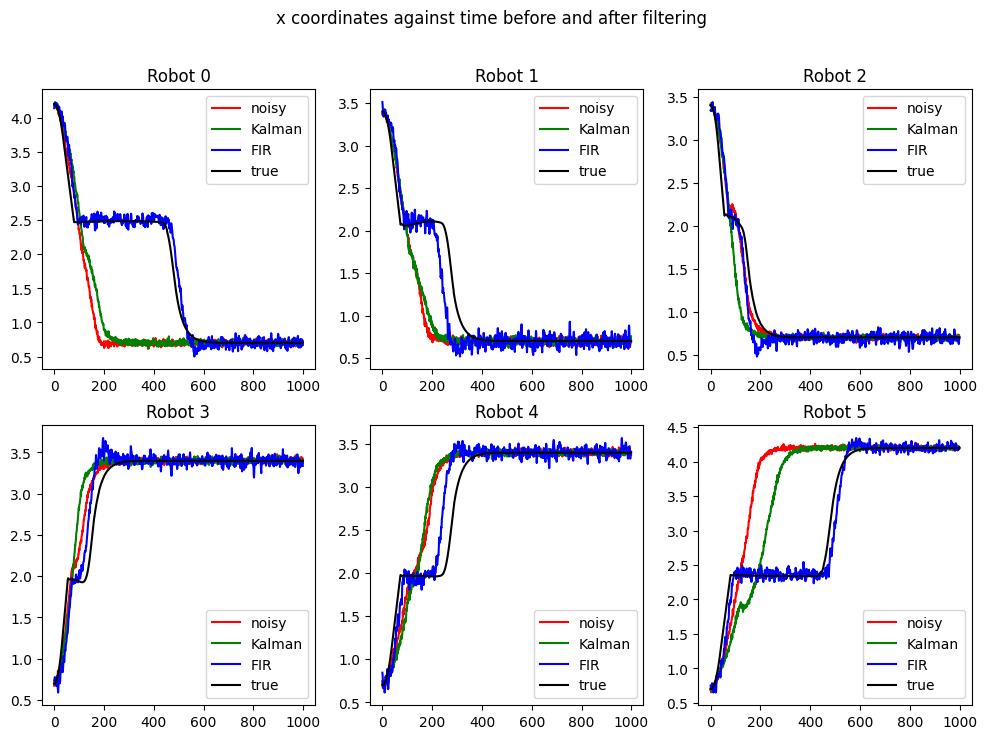

In [8]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("x coordinates against time before and after filtering")

for id in ROBOT_RANGE:
    clean = cleans[id]
    noisy, kalman = noisys[id], kalmans[id]
    fir = firs[id]
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.plot(X_AXES, noisy[X_COL], "r")
    current_ax.plot(X_AXES, kalman[X_COL], "g")
    current_ax.plot(X_AXES, fir[X_COL], "b")
    current_ax.plot(X_AXES, clean[X_COL], "k")
    
    current_ax.legend(("noisy", "Kalman", "FIR", "true"))

In [ ]:
# fig, axs = plt.subplots(2,3)
# fig.set_size_inches(12,8)
# fig.suptitle("coordinates before and after filtering")

# for id in ROBOT_RANGE:
#     clean = cleans[id]
#     noisy_g, filt_g = noisy_gs[id], filt_gs[id]
    
#     current_ax = get_current_ax(axs, id)
#     current_ax.set_title(f"Robot {id}")
#     current_ax.set_xlim(-4.5, 4.5)
#     current_ax.set_ylim(-3, 3)
    
#     current_ax.plot(noisy_g[X_COL], noisy_g[Y_COL], "r")
#     current_ax.plot(filt_g[X_COL], filt_g[Y_COL], "g")
#     current_ax.plot(clean[X_COL], clean[Y_COL], "b")
    
#     current_ax.legend(("noisy", "filtered", "true"))

In [ ]:
def percentage_diff(
    old: float,
    new: float
) -> float:
    return round((new-old) / old * 100, 1)


def diff_squared(t: float, a: float) -> float:
    return (t - a) ** 2


def mean_squared_error(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    param: str,
    id: Union[int, None] = None
    ) -> float:
    if id is not None:
        true_data = extract_robot(true_data, id)
        actual_data = extract_robot(actual_data, id)
        
    return true_data[param].combine(
            other=actual_data[param],
            func=diff_squared
        ).mean()


def vectorify(x: float, y: float) -> np.ndarray:
    return np.array((x, y))


def mean_squared_error_vec(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    id: Union[int, None] = None
    ) -> float:
    if id is not None:
        true_data = extract_robot(true_data, id)
        actual_data = extract_robot(actual_data, id)
    
    true_vec = true_data[X_COL].combine(
        other=true_data[Y_COL],
        func=vectorify
    )
    
    actual_vec = actual_data[X_COL].combine(
        other=actual_data[Y_COL],
        func=vectorify
    )
    
    return (np.linalg.norm(true_vec - actual_vec) ** 2).mean()


baseline_xs = [mean_squared_error(CLEAN_FD, NOISY_FD, X_COL, id) for id in ROBOT_RANGE]

baseline_ys = [mean_squared_error(CLEAN_FD, NOISY_FD, Y_COL, id) for id in ROBOT_RANGE]

baseline_vs = [mean_squared_error_vec(CLEAN_FD, NOISY_FD, id) for id in ROBOT_RANGE]

In [ ]:
# fig, axs = plt.subplots(2,3)
# fig.set_size_inches(12,8)
# fig.suptitle("% change in MSE (dynamic testing)")

# for id in ROBOT_RANGE:
#     baseline_x, baseline_y, baseline_v = baseline_xs[id], baseline_ys[id], baseline_vs[id]

#     error_x = mean_squared_error(
#         CLEAN_FD,
#         FILT_G_FD,
#         X_COL,
#         id
#     )
    
#     error_y = mean_squared_error(
#         CLEAN_FD,
#         FILT_G_FD,
#         Y_COL,
#         id
#     )
    
#     error_v = mean_squared_error_vec(
#         CLEAN_FD,
#         FILT_G_FD,
#         id
#     )
    
#     delta_x = percentage_diff(baseline_x, error_x)
#     delta_y = percentage_diff(baseline_y, error_y)
#     delta_v = percentage_diff(baseline_v, error_v)
    
#     current_ax = get_current_ax(axs, id)
#     current_ax.set_title(f"Robot {id}")
    
#     deltas = [delta_x, delta_y, delta_v]
#     colours = ['red' if d > 0 else 'green' for d in deltas]
#     bars = current_ax.bar([X_COL, Y_COL, V_COL], deltas, color=colours)
#     current_ax.bar_label(bars, label_type='center')

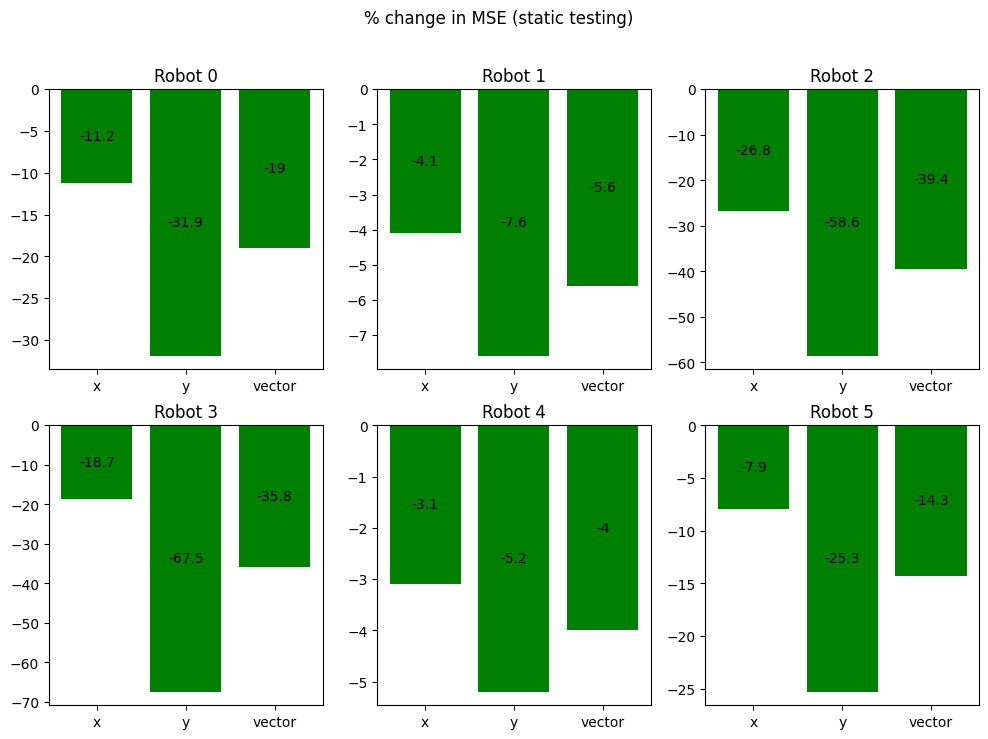

In [ ]:
# fig, axs = plt.subplots(2,3)
# fig.set_size_inches(12,8)
# fig.suptitle("% change in MSE (static testing)")

# for id in ROBOT_RANGE:
#     baseline_x, baseline_y, baseline_v = baseline_xs[id], baseline_ys[id], baseline_vs[id]
#     filter = Kalman_filter()
    
#     clean = extract_robot(CLEAN_FD, id)
#     noisy = extract_robot(NOISY_FD, id)
#     filtered = pd.DataFrame(columns=COLS)
    
#     for (_, entry) in noisy.iterrows():
#         (x_f, y_f, th_f) = filter.step([
#             entry[X_COL],
#             entry[Y_COL],
#             entry[TH_COL]
#         ])
        
#         new_row = pd.DataFrame(
#             {
#                 X_COL: x_f,
#                 Y_COL: y_f,
#                 TH_COL: th_f
#             },
#             index=[0]
#         )
        
#         filtered = pd.concat([filtered, new_row], ignore_index=True)
    
#     filtered = filtered.reset_index(drop=True)

#     error_x = mean_squared_error(
#         clean,
#         filtered,
#         X_COL
#     )
    
#     error_y = mean_squared_error(
#         clean,
#         filtered,
#         Y_COL
#     )
    
#     error_v = mean_squared_error_vec(
#         clean,
#         filtered
#     )
    
#     delta_x = percentage_diff(baseline_x, error_x)
#     delta_y = percentage_diff(baseline_y, error_y)
#     delta_v = percentage_diff(baseline_v, error_v)
        
#     current_ax = get_current_ax(axs, id)
#     current_ax.set_title(f"Robot {id}")
#     deltas = [delta_x, delta_y, delta_v]
#     colours = ['red' if d > 0 else 'green' for d in deltas]
#     bars = current_ax.bar([X_COL, Y_COL, V_COL], deltas, color=colours)
#     current_ax.bar_label(bars, label_type='center')

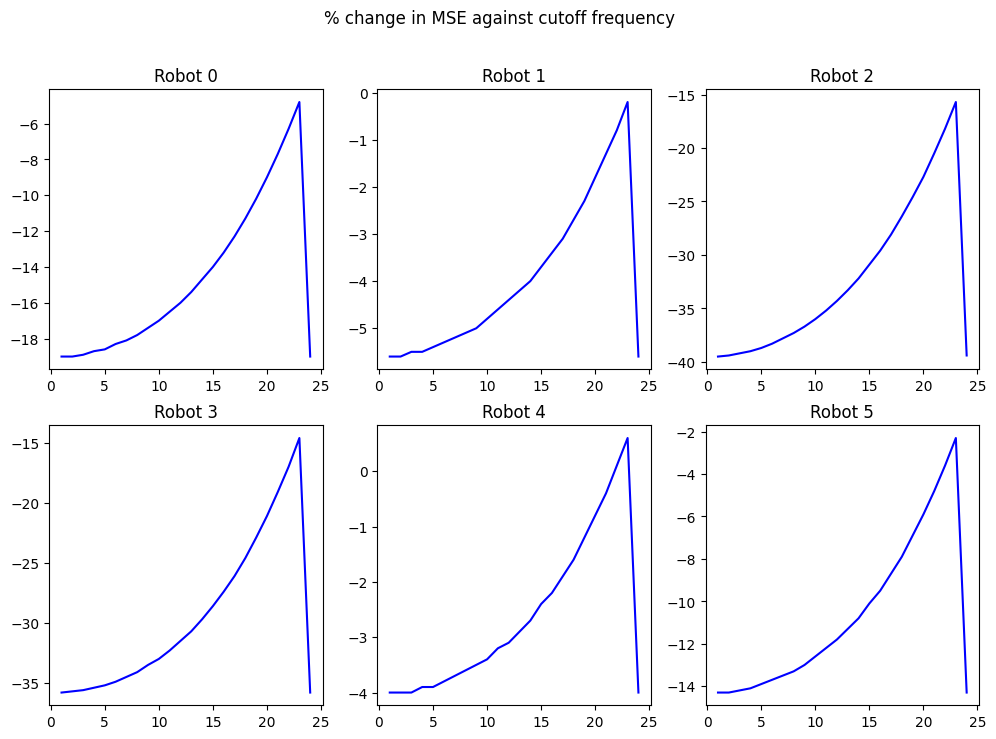

In [ ]:
# fig, axs = plt.subplots(2,3)
# fig.set_size_inches(12,8)
# fig.suptitle("% change in MSE against cutoff frequency")

# CUTOFFS = range(1, 25)

# for id in ROBOT_RANGE:
#     delta_v = []

#     baseline_v = baseline_vs[id]

#     for c in CUTOFFS:
#         filter = FIR_filter(cutoff=c)
        
#         clean = extract_robot(CLEAN_FD, id)
#         noisy = extract_robot(NOISY_G_FD, id)
#         filtered = pd.DataFrame(columns=COLS)
        
#         for (_, entry) in noisy.iterrows():
#             (x_f, y_f, th_f) = filter.step([
#                 entry[X_COL],
#                 entry[Y_COL],
#                 entry[TH_COL]
#             ])
            
#             new_row = pd.DataFrame(
#                 {
#                     X_COL: x_f,
#                     Y_COL: y_f,
#                     TH_COL: th_f
#                 },
#                 index=[0]
#             )
            
#             filtered = pd.concat([filtered, new_row], ignore_index=True)
        
#         filtered = filtered.reset_index(drop=True)

#         error_v = mean_squared_error_vec(
#             clean,
#             filtered
#         )

#         delta_v.append(percentage_diff(baseline_v, error_v))
        
#     current_ax = get_current_ax(axs, id)
#     current_ax.set_title(f"Robot {id}")
#     current_ax.plot(CUTOFFS, delta_v, "b")

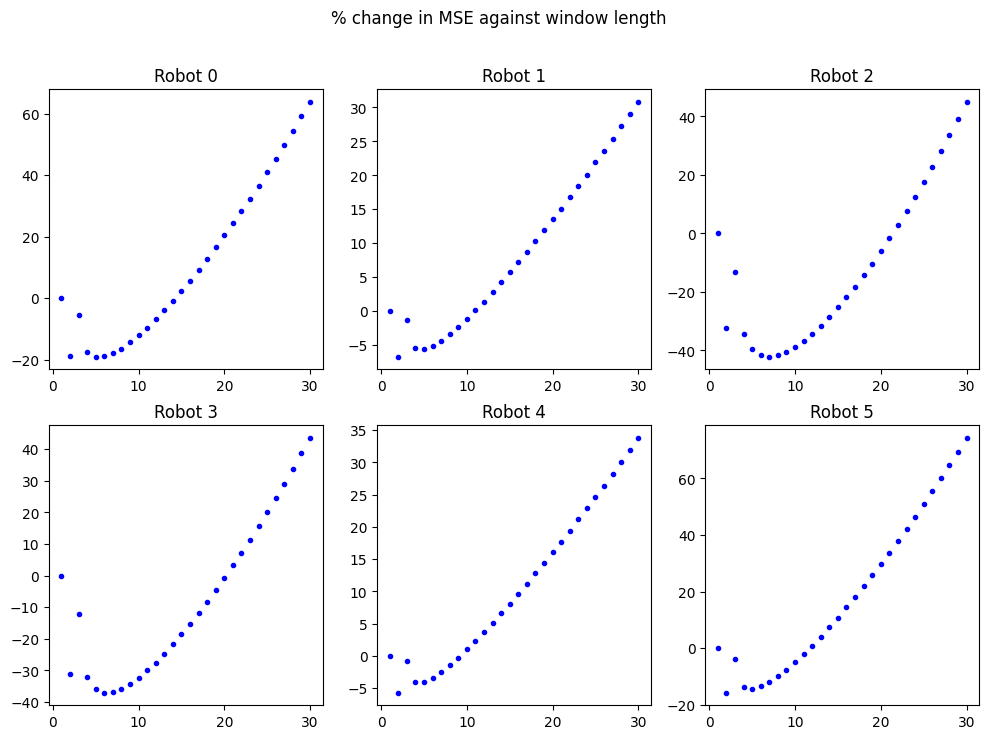

In [ ]:
# fig, axs = plt.subplots(2,3)
# fig.set_size_inches(12,8)
# fig.suptitle("% change in MSE against window length")

# WINDOWS = range(1, 31)

# for id in ROBOT_RANGE:
#     delta_v = []

#     baseline_v = baseline_vs[id]

#     for w in WINDOWS:
#         filter = FIR_filter(window_len=w)
        
#         clean = cleans[id]
#         noisy_g = noisy_gs[id]
#         filtered = pd.DataFrame(columns=COLS)
        
#         for (_, entry) in noisy_g.iterrows():
#             (x_f, y_f, th_f) = filter.step([
#                 entry[X_COL],
#                 entry[Y_COL],
#                 entry[TH_COL]
#             ])
            
#             new_row = pd.DataFrame(
#                 {
#                     X_COL: x_f,
#                     Y_COL: y_f,
#                     TH_COL: th_f
#                 },
#                 index=[0]
#             )
            
#             filtered = pd.concat([filtered, new_row], ignore_index=True)
        
#         filtered = filtered.reset_index(drop=True)

#         error_v = mean_squared_error_vec(
#             clean,
#             filtered
#         )

#         delta_v.append(percentage_diff(baseline_v, error_v))
        
#     current_ax = get_current_ax(axs, id)
#     current_ax.set_title(f"Robot {id}")
#     current_ax.plot(WINDOWS, delta_v, ".b")